Generation 1: Best Fitness = 4.562770922177208
Generation 2: Best Fitness = 3.3283401769991845
Generation 3: Best Fitness = 3.3283401769991845
Generation 4: Best Fitness = 3.3283401769991845
Generation 5: Best Fitness = 3.1701601456257618
Generation 6: Best Fitness = 3.1701601456257618
Generation 7: Best Fitness = 0.9250897132833669
Generation 8: Best Fitness = 0.9250897132833669
Generation 9: Best Fitness = 0.9250897132833669
Generation 10: Best Fitness = 0.9250897132833669
Generation 11: Best Fitness = 0.6480599734020669
Generation 12: Best Fitness = 0.4443752263909322
Generation 13: Best Fitness = 0.4443752263909322
Generation 14: Best Fitness = 0.24408092361789402
Generation 15: Best Fitness = 0.15097439711201277
Generation 16: Best Fitness = 0.0788182114931435
Generation 17: Best Fitness = 0.05807289047929176
Generation 18: Best Fitness = 0.054546675338180695
Generation 19: Best Fitness = 0.04245373667454588
Generation 20: Best Fitness = 0.04245373667454588
Generation 21: Best Fit

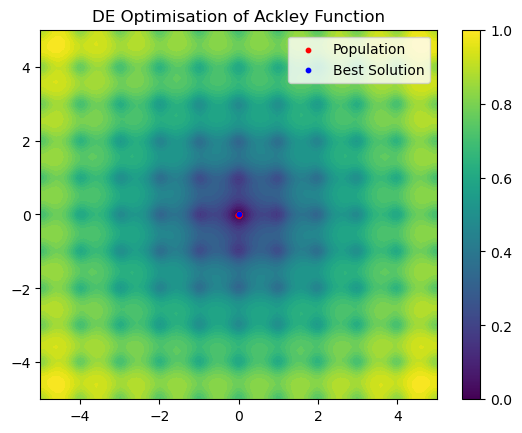

ValueError: unknown file extension: .mp4

In [8]:
import numpy as np
from scipy.stats import qmc  # For Latin Hypercube Sampling
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import glob


# Objective function (Ackley function used as an example)
def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
    term1 = -a * np.exp(-b * np.sqrt(0.5 * (x**2 + y**2)))
    term2 = -np.exp(0.5 * (np.cos(c * x) + np.cos(c * y)))
    return term1 + term2 + a + np.exp(1)

# Objective function (Ackley function used as an example)
# def ackley_function(x, y, a=20, b=0.2, c=2 * np.pi):
#     z = np.sin(x)+(x*np.cos(0.5*y))
#     return z

def objective_function(vec):
    """Objective function wrapper for optimization.
    Args:
        vec (np.ndarray): A vector representing candidate solution (x, y).
    Returns:
        float: Fitness value of the solution.
    """
    x, y = vec
    return ackley_function(x, y)

# Differential Evolution Optimizer
class DifferentialEvolution:
    def __init__(self, bounds, pop_size=50, mutation_factor=0.8, crossover_prob=0.7, max_generations=100, method='random'):
        """
        Initialize the Differential Evolution (DE) optimizer.
        
        Parameters:
        bounds (list of tuple): List of (min, max) bounds for each dimension.
        pop_size (int): Number of candidate solutions in the population.
        mutation_factor (float): Scaling factor for mutation [0, 2].
        crossover_prob (float): Crossover probability [0, 1].
        max_generations (int): Maximum number of generations to evolve.
        method (str): Population initialization method ('random' or 'lhs').
        """
        self.bounds = np.array(bounds)
        self.dimensions = len(bounds)
        self.pop_size = pop_size
        self.mutation_factor = mutation_factor
        self.crossover_prob = crossover_prob
        self.max_generations = max_generations
        self.method = method
        
        # Initialize population
        self.population = self.initialize_population()
        self.best_solution = None
        self.best_fitness = np.inf
    
    def initialize_population(self):
        """Initialize population using random sampling or Latin Hypercube Sampling."""
        if self.method == 'lhs':
            # Latin Hypercube Sampling
            sampler = qmc.LatinHypercube(d=self.dimensions)
            sample = sampler.random(n=self.pop_size)
            population = qmc.scale(sample, self.bounds[:, 0], self.bounds[:, 1])
        else:
            # Random Sampling
            population = np.random.rand(self.pop_size, self.dimensions)
            for i in range(self.dimensions):
                population[:, i] = self.bounds[i, 0] + population[:, i] * (self.bounds[i, 1] - self.bounds[i, 0])
        
        return population
    
    def mutate(self, target_idx):
        """Mutation using DE/best/1 strategy."""
        # Choose three random and distinct individuals different from target_idx
        indices = [idx for idx in range(self.pop_size) if idx != target_idx]
        np.random.shuffle(indices)
        r1, r2 , r3= indices[:3]
        
        # Best individual in current population
        best_idx = np.argmin([objective_function(ind) for ind in self.population])
        best = self.population[best_idx]
        
        # Mutant vector: v = best + F * (r1 - r2)
        mutant = best + self.mutation_factor * (self.population[r1] - self.population[r2])
        
        # Ensure mutant vector is within bounds
        mutant = np.clip(mutant, self.bounds[:, 0], self.bounds[:, 1])
        
        return mutant
    
    def crossover(self, target, mutant):
        """Crossover to create trial vector."""
        trial = np.copy(target)
        for i in range(self.dimensions):
            if np.random.rand() < self.crossover_prob or i == np.random.randint(self.dimensions):
                trial[i] = mutant[i]
        return trial
    
    def select(self, target, trial):
        """Selection: Return the individual with the better fitness."""
        if objective_function(trial) < objective_function(target):
            return trial
        return target
    
    def optimize(self):
        """Run the Differential Evolution optimization."""
        x_range = np.linspace(-5, 5, 100)
        y_range = np.linspace(-5, 5, 100)
        X, Y = np.meshgrid(x_range, y_range)
        Z = ackley_function(X, Y)

        for generation in range(self.max_generations):
            new_population = np.zeros_like(self.population)
            
            for i in range(self.pop_size):
                target = self.population[i]
                mutant = self.mutate(i)
                trial = self.crossover(target, mutant)
                new_population[i] = self.select(target, trial)
            
            # Update the population
            self.population = new_population
            
            # Track the best solution
            best_idx = np.argmin([objective_function(ind) for ind in self.population])
            best_fitness = objective_function(self.population[best_idx])
            
            if best_fitness < self.best_fitness:
                self.best_fitness = best_fitness
                self.best_solution = self.population[best_idx]

            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S_%f")

            
            plt.contourf(X, Y, Z, levels=50, cmap='viridis')
            plt.scatter(de.population[:, 0], de.population[:, 1], color='red', label='Population', s=10)
            # plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=100)
            plt.legend()
            plt.title("DE Optimisation of Ackley Function")
            plt.colorbar()
            plt.savefig(f'DEPlots/{timestamp}.png')
            # plt.show()
            plt.close()
            # Debug information
            print(f"Generation {generation + 1}: Best Fitness = {self.best_fitness}")
        
        return self.best_solution, self.best_fitness

# Example usage of Differential Evolution
bounds = [(-5, 5), (-5, 5)]  # Define bounds for each dimension (x and y)

# Initialize the DE optimizer
de = DifferentialEvolution(bounds=bounds, pop_size=20, max_generations=30, method='lhs')

# Run the optimization
best_solution, best_fitness = de.optimize()

# Output the results
print(f"Best Solution: {best_solution}, Best Fitness: {best_fitness}")

# Plotting the final population and best solution (optional)
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = ackley_function(X, Y)

plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.scatter(de.population[:, 0], de.population[:, 1], color='red', label='Population', s=10)
plt.scatter(best_solution[0], best_solution[1], color='blue', label='Best Solution', s=10)
plt.legend()
plt.title("DE Optimisation of Ackley Function")
plt.colorbar()
plt.show()

image_files = sorted(glob.glob("DEPlots/*.png"))
# print('here')
images = [Image.open(img) for img in image_files]

# Step 3: Save images as a GIF
if images:
    # 'duration' is the time each frame stays on screen (milliseconds)
    images[0].save(
        "DEOptimiser.mp4",
        save_all=True,
        append_images=images[1:],  # Include the rest of the images
        duration=400,               # Duration of each frame in milliseconds
        loop=0                       # 0 means loop indefinitely
    )